In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain.tools import tool, ToolRuntime

@tool
def read_email(runtime: ToolRuntime) -> str:
    """
    Read an email from the given address.
    """
    # Take email from state
    return runtime.state["email"]


@tool
def send_email(runtime: ToolRuntime) -> str:
    """
    Send an email to the given address with the given subject and body.
    """
    # Fake email sending
    return "Email Sent"

In [3]:
from langchain.agents import create_agent, AgentState
from langgraph.checkpoint.memory import InMemorySaver
from langchain.agents.middleware import HumanInTheLoopMiddleware

class EmailState(AgentState):
    email: str

agent = create_agent(
    model="gpt-5-nano",
    tools=[read_email, send_email],
    state_schema=EmailState,
    checkpointer=InMemorySaver(),
    middleware={
        HumanInTheLoopMiddleware(
            interrupt_on={
                "read_email": False,
                "send_email": True
            },
            description_prefix="Tool execution requires approval"
        )
    }
)

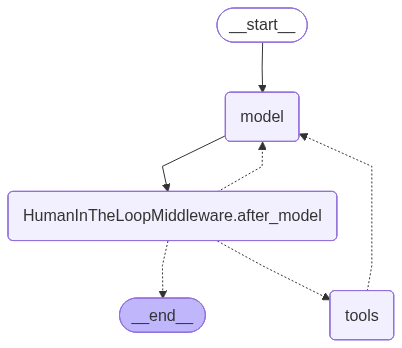

In [4]:
agent

In [5]:
from langchain.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}

user_query = HumanMessage(content="Please read my email and send a response.")

response = agent.invoke(
    {
        "messages": [user_query],
        "email": "Hi Sean, I'm going to be late for our meeting tomorrow. Can we reschedule? Best, David."
    },
    config=config
)

In [6]:
from pprint import pprint

pprint(response)

{'__interrupt__': [Interrupt(value={'action_requests': [{'args': {'body': 'Hi '
                                                                          'David,\n'
                                                                          '\n'
                                                                          'No '
                                                                          'problem—thanks '
                                                                          'for '
                                                                          'the '
                                                                          'heads '
                                                                          'up. '
                                                                          'We '
                                                                          'can '
                                                                          'reschedule. '
        

In [7]:
pprint(response["__interrupt__"])

[Interrupt(value={'action_requests': [{'args': {'body': 'Hi David,\n'
                                                        '\n'
                                                        'No problem—thanks for '
                                                        'the heads up. We can '
                                                        'reschedule. Here are '
                                                        'a few options for '
                                                        'tomorrow:\n'
                                                        '\n'
                                                        '- 10:00 AM\n'
                                                        '- 2:00 PM\n'
                                                        '- 4:30 PM\n'
                                                        '\n'
                                                        'If none of these '
                                                        'work, please sh

In [8]:
# Access the "body" argument from the tool call
print(response["__interrupt__"][0].value["action_requests"][0]["args"]["body"])

Hi David,

No problem—thanks for the heads up. We can reschedule. Here are a few options for tomorrow:

- 10:00 AM
- 2:00 PM
- 4:30 PM

If none of these work, please share a couple of times that suit you and I’ll adjust.

Best regards,
Sean


https://smith.langchain.com/public/c20972c5-ec60-47cf-8789-c54f1872e083/r

## Approve

In [ ]:
from langgraph.types import Command

response = agent.invoke(
    Command(
        resume={
            "decisions": [
                {"type": "approve"}
            ]
        }
    ),
    config=config # Same thread ID to resume the pasued conversation
)

pprint(response)

{'email': "Hi Sean, I'm going to be late for our meeting tomorrow. Can we "
          'reschedule? Best, David.',
 'messages': [HumanMessage(content='Please read my email and send a response.', additional_kwargs={}, response_metadata={}, id='6bd95902-71e0-40b2-b85a-931b9235cda6'),
              AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 595, 'prompt_tokens': 151, 'total_tokens': 746, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 576, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-Ctg2d9vFCOry2mcBskY0tVtxG8iv5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b8065-56c5-78b2-b123-3050e87529e1-0', tool_calls=[{'name': 'read_email', 'args': {}, 'id': 'call_E

https://smith.langchain.com/public/03686cf0-3a4e-4671-9431-5857c9b945c2/r

## Reject

In [13]:
config_2 = {"configurable": {"thread_id": "2"}}

user_query = HumanMessage(content="Please read my email and send a response.")

response = agent.invoke(
    {
        "messages": [user_query],
        "email": "Hi Tim, I'm going to be late for our meeting tomorrow. Can we reschedule? Best, Will."
    },
    config=config_2
)

pprint(response)

{'__interrupt__': [Interrupt(value={'action_requests': [{'args': {'body': 'Hi '
                                                                          'Will,\n'
                                                                          '\n'
                                                                          'Thanks '
                                                                          'for '
                                                                          'the '
                                                                          'heads '
                                                                          'up '
                                                                          '— '
                                                                          'no '
                                                                          'problem '
                                                                          'rescheduling. '
             

https://smith.langchain.com/public/8467b7b5-c0a4-4120-9820-937a1718efb5/r

In [15]:
response = agent.invoke(
    Command(
        resume={
            "decisions": [
                {
                    "type": "reject",
                    # An explanation of why the request was rejected
                    "message": "No please sign off - Your merciful leader, Will."
                }
            ]
        }
    ),
    config=config_2 # Same thread ID to resume the paused conversation
)

pprint(response)

{'__interrupt__': [Interrupt(value={'action_requests': [{'args': {'body': 'Hi '
                                                                          'Will,\n'
                                                                          '\n'
                                                                          'Thanks '
                                                                          'for '
                                                                          'the '
                                                                          'heads '
                                                                          'up '
                                                                          '— '
                                                                          'no '
                                                                          'problem '
                                                                          'rescheduling. '
             

https://smith.langchain.com/public/f3077028-ef14-40d7-9f17-23130ced8280/r

## Edit

In [18]:
config_edit = {"configurable": {"thread_id": "99"}}

user_query = HumanMessage(content="Please read my email and send a response.")

response = agent.invoke(
    {
        "messages": [user_query],
        "email": "Hi Robert, I'm going to be late for our meeting tomorrow. Can we reschedule? Best, Billy."
    },
    config=config_edit
)

pprint(response)

{'__interrupt__': [Interrupt(value={'action_requests': [{'args': {'body': 'Hi '
                                                                          'Billy,\n'
                                                                          '\n'
                                                                          'No '
                                                                          'problem—thanks '
                                                                          'for '
                                                                          'letting '
                                                                          'me '
                                                                          'know. '
                                                                          'We '
                                                                          'can '
                                                                          'reschedule. '
     

https://smith.langchain.com/public/402125da-e4e2-4b09-b2eb-52bcabe3fe82/r

In [19]:
response = agent.invoke(
    Command(
        resume={
            "decisions": [
                {
                    "type": "edit",
                    # Edited action with tool anme and args
                    "edited_action": {
                        # Tool name to call.
                        # Will usually be the same as the original action.
                        "name": "send_email",
                        # Arguments to pass to the tool.
                        "args": {
                            "body": "This is the last straw, you're fired!"
                        }
                    }
                }
            ]
        }
    ),
    config=config_edit # Same thread ID to resume the paused conversation
)

pprint(response)

{'email': "Hi Robert, I'm going to be late for our meeting tomorrow. Can we "
          'reschedule? Best, Billy.',
 'messages': [HumanMessage(content='Please read my email and send a response.', additional_kwargs={}, response_metadata={}, id='cbc99812-4b99-4f58-a3a3-22d1a0361856'),
              AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 403, 'prompt_tokens': 151, 'total_tokens': 554, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 384, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CtgMtlPyX7blEFRBmMzGLLFmokCkw', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b8078-7e8c-7a50-a244-9df9d26d16c1-0', tool_calls=[{'name': 'read_email', 'args': {}, 'id': 'call

https://smith.langchain.com/public/ce609b97-b3a4-449b-9ba8-13aef007bebc/r

## Instructor Comment

I use ChatGPT all the time and, over time, tend to start thinking that the model is the Chat application. But really, there is a UI that takes my input, when I hit return, sends it to the model, receives a response, and displays it. The model is like a function and does not (in general) persist data beyond the duration of the query. 

Similarly,  our agent (which is, under the hood, a langgraph graph) is just called like a function. It executes and returns its result. With memory, you can persist information across invocations - but the agent is not running between invocations.  

So, the 'continuous' part of the continuous chat session you describe is provided by your application. The chat UI/program is running, maintaining contact with the user.

So, you would not, in general, use the interrupt mechanism to provide the normal query-response of a chat. That is provided by sending a query, calling the agent, it provides a response and then terminates and then the UI displays the response. 

So, what do you use the interrupt for?
You use this when there is something exceptional that needs to interrupt the agent mid-action. So, you aren't finished responding to the query, but you need to check to see if the answer is in English or Swedish. Without the interrupt, the agent would have to save away its current state, terminate, and then find where it was when it is called again. The interrupt allows you to suspend current operation - keeping all the state where it is at, and then pick up again when the response is provided.

